# 从零开始实现线性回归

## 准备数据

In [1]:
%matplotlib inline
import random
import torch
from matplotlib import pyplot as plt

In [2]:
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
#     print(X)
    y = torch.matmul(X, w) + b
#     print(y)
    y += torch.normal(0, 0.01, y.shape)
#     print(y)
    return X, y.reshape(-1, 1)

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

print(features[0], labels[0])

tensor([ 0.4422, -1.2193]) tensor([9.2238])


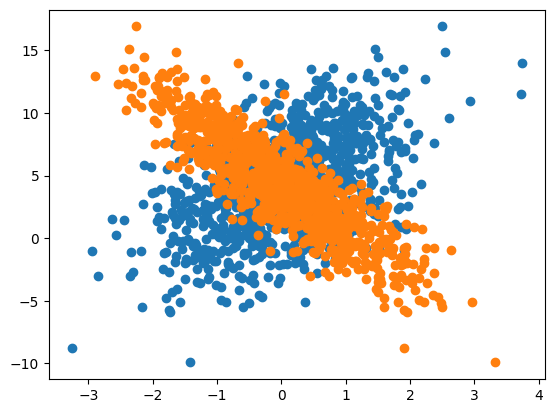

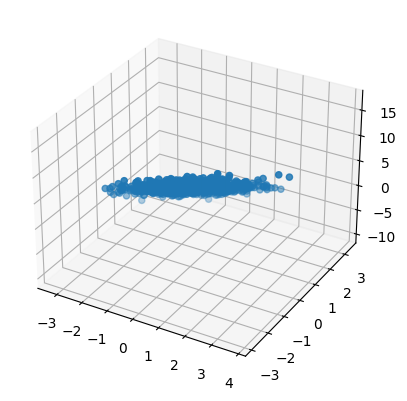

In [3]:
plt.scatter(features[:, 0], labels)
plt.scatter(features[:, 1], labels)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(features[:, 0], features[:, 1], labels)

In [4]:
def data_iter(features, labels, batch_size):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        
batch_size = 10
for X, y in data_iter(features, labels, batch_size):
    print(X, "\n", y)
    break

tensor([[ 0.4133, -1.0658],
        [-0.2451,  0.6332],
        [-1.4911,  0.9430],
        [-0.4679,  0.3117],
        [-1.2076,  0.1675],
        [ 1.0032, -0.5205],
        [ 0.0392, -2.3195],
        [-0.1966, -0.5886],
        [ 0.7579,  1.4827],
        [-1.3262, -0.7481]]) 
 tensor([[ 8.6356],
        [ 1.5720],
        [-2.0124],
        [ 2.2022],
        [ 1.2119],
        [ 7.9845],
        [12.1790],
        [ 5.8165],
        [ 0.6875],
        [ 4.0869]])


## 初始化模型参数

In [5]:
w = torch.normal(0, 0.01, size=[2, 1], requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 定义模型

In [6]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

## 定义损失函数

In [7]:
def sqaure_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 定义优化算法

In [8]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

# 训练

In [9]:
lr = 0.03
num_epoches = 3
net = linreg
loss = sqaure_loss

for epoch in range(num_epoches):
    for X, y in data_iter(features, labels, batch_size):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f"epoch {epoch}, loss {float(train_l.mean()):f}")

epoch 0, loss 0.035037
epoch 1, loss 0.000121
epoch 2, loss 0.000051


In [10]:
print(w, b)
print(true_w, true_b)

tensor([[ 2.0003],
        [-3.3994]], requires_grad=True) tensor([4.1992], requires_grad=True)
tensor([ 2.0000, -3.4000]) 4.2


# 简洁实现 softmax 回归

In [66]:
import torch
from torch import nn
from torchvision import datasets, transforms
import torchvision
from matplotlib_inline import backend_inline
from d2l import torch as d2l
from IPython import display

In [67]:
batch_size = 256
trans = transforms.Compose([transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root="./data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.MNIST(root="./data", train=False, transform=trans, download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False)

In [68]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [69]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [70]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        backend_inline.set_matplotlib_formats('svg')
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [71]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [72]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """Train a model (defined in Chapter 3).

    Defined in :numref:`sec_softmax_scratch`"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc


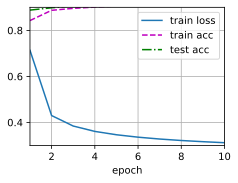

In [73]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
def init_weight(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weight)

loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

num_epochs = 10
train_ch3(net, train_loader, test_loader, loss, num_epochs, trainer)

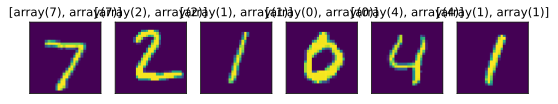

In [88]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = y
    preds = net(X).argmax(axis=1)
    
    titles = [[true.numpy(), pred.numpy()] for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_loader)

In [89]:
print(net)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)
